# Minimal model
## Comparing activation functions for a minimal model
The opposing paper argues that input compression is merely an artifact of double saturated activation functions. We test this assumption for the minimal model in a numeric simulation. We look at the development of mututal information with the input in a one neuron model with growing weights and compare different activation functions.

In [1]:
import numpy as np
np.random.seed(0)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

In [13]:
weights = np.arange(0.1, 8, 0.1)

In [14]:
weights

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9])

The input is sampled from a standard normal distribution.

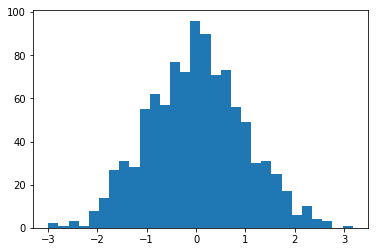

In [15]:
input_distribution = stats.norm()
input_ = input_distribution.rvs(1000)
plt.hist(input_, bins=30);

The input is multiplied by the different weights. This is the pass from the input neuron to the hidden neuron.

In [16]:
net_input = np.outer(weights, input_)

The activation functions we want to test.

In [17]:
def hard_sigmoid(x):
    lower_bound = -2.5
    upper_bound = 2.5
    linear = 0.2 * x + 0.5
    linear[x < lower_bound] = 0
    linear[x > upper_bound] = 1
    return linear

def linear(x):
    return x

activation_functions = [tf.nn.sigmoid, tf.nn.tanh, tf.nn.relu, tf.nn.softsign, tf.nn.softplus, hard_sigmoid, 
                       tf.nn.selu, tf.nn.relu6, tf.nn.elu, tf.nn.leaky_relu, linear]

First we look at the shape of the different activation functions. We see that some are double saturated like `tanh` and some are not like `relu`.

AttributeError: 'EagerTensor' object has no attribute 'ndim'

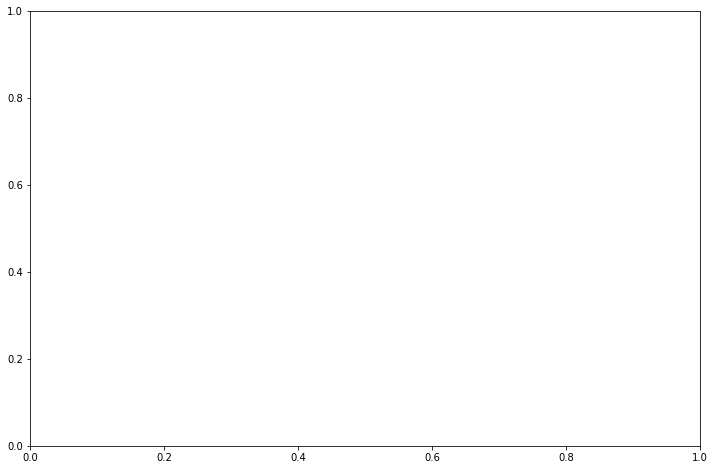

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
for activation_function in activation_functions:
    x = np.linspace(-5,5,100)
    ax.plot(x, activation_function(x), label=activation_function.__name__)
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=int(len(activation_functions)/3)+1, ncols=3, figsize=(10, 10))
axes = axes.flat

for i, actvation_function in enumerate(activation_functions):
    x = np.linspace(-10,10,100)
    axes[i].plot(x, actvation_function(x))
    axes[i].set(title=actvation_function.__name__)
    
# Remove unused plots.
for ax in axes:
    if not ax.lines:
        ax.axis('off')
    

plt.tight_layout()
plt.show()

Apply the activation functions to the weighted inputs.

In [ ]:
outputs = {}
for actvation_function in activation_functions:
    try:
        outputs[actvation_function.__name__] = actvation_function(net_input).numpy()
    except AttributeError:
        outputs[actvation_function.__name__] = actvation_function(net_input)

We now estimate the discrete mututal information between the input $X$ and the activity of the hidden neuron $Y$, which is in this case also the output. $H(Y|X) = 0$, since $Y$ is a deterministic function of $X$. Therefore

\begin{align}
I(X;Y) &= H(Y) - H(Y|X)\\
       &= H(Y)\\
\end{align}

The entropy of the input is 

In [19]:
dig, _ = np.histogram(input_, 50)
print(f'{stats.entropy(dig, base=2):.2f} bits')

4.98 bits


In the paper a fixed number of bins is evenly distributed between the minimum and the maximum activation over all weight values. The result below is indeed comparable to the paper and shows that mutual information decreases only in double saturated activation functions, while it increases otherwise.

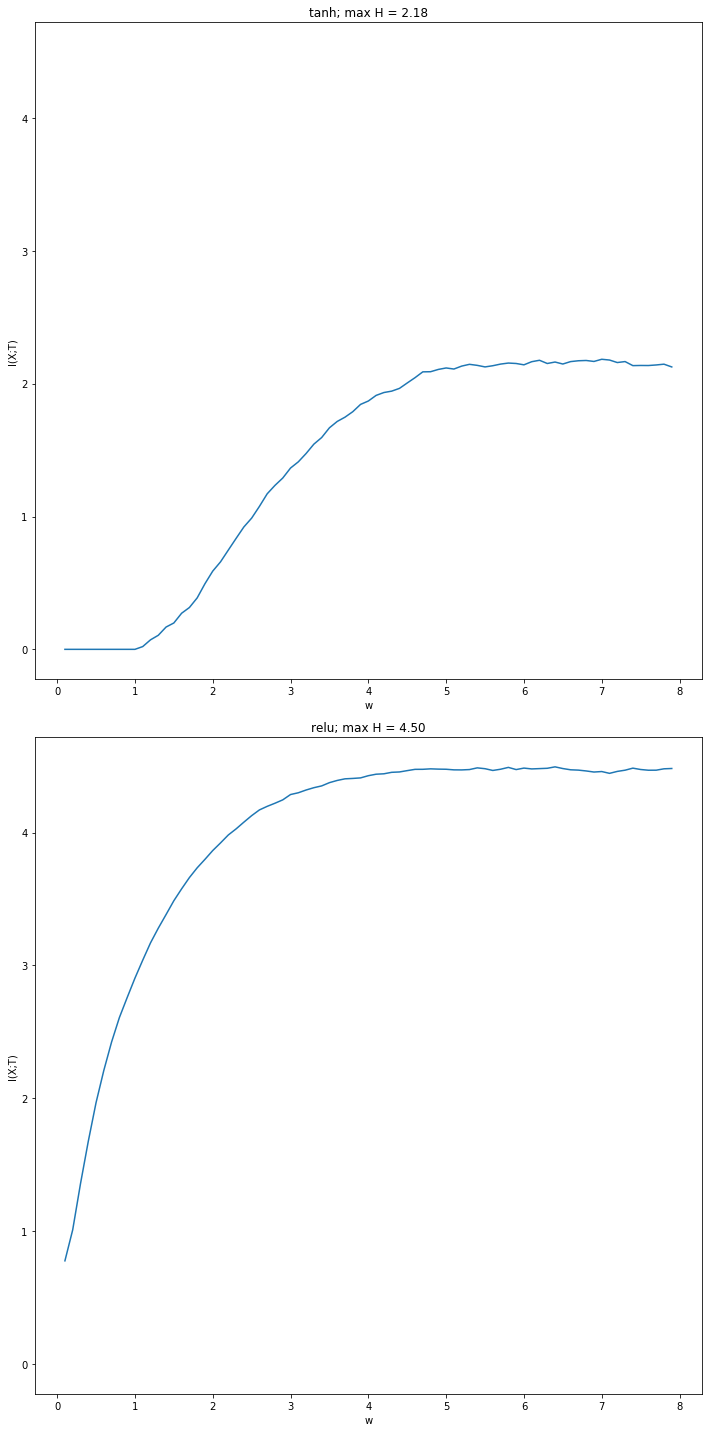

In [20]:
fig, ax = plt.subplots(nrows=len(outputs), figsize=(10, 20), sharey=True)
ax = ax.flat
for ax_idx, (activation_function, Y) in enumerate(outputs.items()):
    min_acitivity = Y.min()
    max_acitivity = Y.max()
    
    mi = np.zeros(len(weights))
    for i in range(len(weights)):
        bins = np.linspace(min_acitivity, max_acitivity, 50)
        digitized, _ = np.histogram(Y[i], bins=bins)
        
        mi[i] = stats.entropy(digitized, base=2) 

    ax[ax_idx].plot(weights,  mi)
    ax[ax_idx].set(title=f'{activation_function}; max H = {mi.max():.2f}', xlabel='w', ylabel='I(X;T)') 
plt.tight_layout()

Yet the fact that mutual information increases even in the linear case is a result of binning between the **minimum and the maximum activation of all neurons**. It raises the question whether this approch is sensible at all or whether binning boundaries should be determined for each simulated weight value seperately. We compare the approach with creating a fixed number of bins between the **minimum and the maximum activity for each weight**.

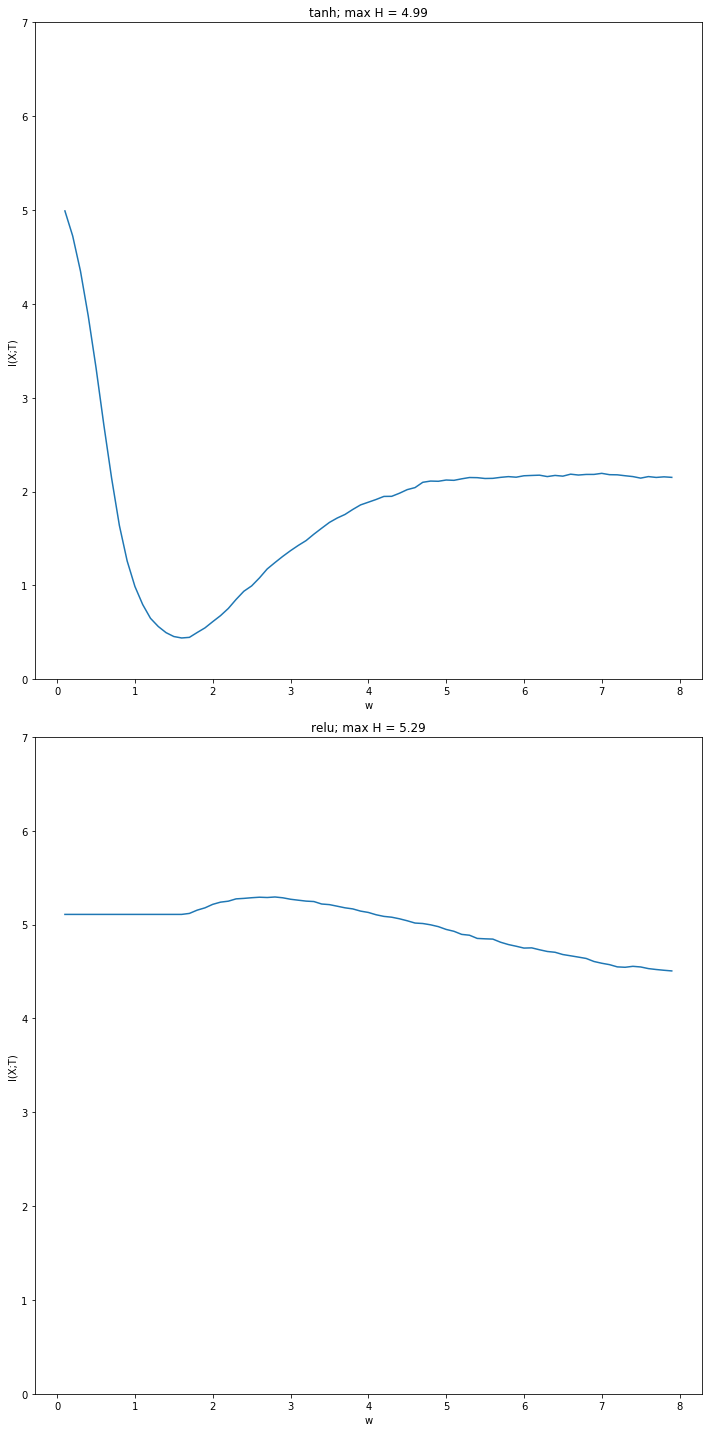

In [21]:
fig, ax = plt.subplots(nrows=len(outputs), figsize=(10, 20), sharey=True)
ax = ax.flat
for ax_idx, (activation_function, Y) in enumerate(outputs.items()):
    
    mi = np.zeros(len(weights))
    for i in range(len(weights)):
        digitized, _ = np.histogram(Y[i], bins=50)
        mi[i] = stats.entropy(digitized, base=2) 

    ax[ax_idx].plot(weights,  mi)
    ax[ax_idx].set(title=f'{activation_function}; max H = {mi.max():.2f}', xlabel='w', ylabel='I(X;T)', ylim=[0,7]) 
    
plt.tight_layout()
plt.show()

This gives a more sensible result. The mutual information is now constant in the linear case and has the same value as the entropy of the input. We now see that mutual information stays constant for many non saturated activation functions, while it still decreases for double saturated functions. Yet it also decreases for some non-double saturated functions such as `elu` and `softplus`. 

Moreover, we see that some activation functions produce distributions with a higher maximum entropy than the input distribution. While it is known that the data processing inequality does no longer hold after the addition noise through binning, it should be investigated whether this is a systematic effect.

It also needs to be determined which way of binning (over the global range or over the range for each weight) is valid.

## Adding bias to the minimal model
This is a further investigation into observe the behavior of a minimal model. We observed in the experiment `10. initial_bias`, that adding a bias to ReLu-activation functions can supress immediate compression. So by adding a bias one could show, that ReLu compresses. 

In this notebook this behavior is recreated for a minimal model. The behavior of the mininmal model with a ReLu- and TanH-activation function can be observed for adding different biases.

In [2]:
weights = np.arange(0.1, 8, 0.1)

In [3]:
weights

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9])

The input is sampled from a standard normal distribution.

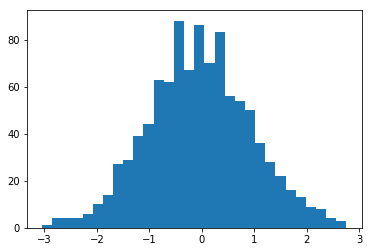

In [4]:
input_distribution = stats.norm()
input_ = input_distribution.rvs(1000)
plt.hist(input_, bins=30);

The input is multiplied by the different weights. This is the pass from the input neuron to the hidden neuron.

In [5]:
net_input = np.outer(weights, input_)

The activation functions we want to test.

In [6]:
activation_functions = [tf.nn.tanh, tf.nn.relu]

Apply the activation functions to the weighted inputs.

In [7]:
outputs = {}
for actvation_function in activation_functions:
    try:
        outputs[actvation_function.__name__] = actvation_function(net_input).numpy()
    except AttributeError:
        outputs[actvation_function.__name__] = actvation_function(net_input)

We now estimate the discrete mututal information between the input $X$ and the activity of the hidden neuron $Y$, which is in this case also the output. $H(Y|X) = 0$, since $Y$ is a deterministic function of $X$. Therefore

\begin{align}
I(X;Y) &= H(Y) - H(Y|X)\\
       &= H(Y)\\
\end{align}

The entropy of the input is 

In [8]:
dig, _ = np.histogram(input_, 50)
print(f'{stats.entropy(dig, base=2):.2f} bits')

5.11 bits


The bias values are

In [9]:
bias_values = [0, 1, 2, 3, 4, 5]

To the input for every activation function a bias is added.

In [10]:
outputs_with_bias = {}
for bias_value in bias_values:
    outputs = {}
    for actvation_function in activation_functions:
        try:
            net_input_bias = net_input + bias_value
            outputs[actvation_function.__name__] = actvation_function(net_input_bias).numpy()
        except AttributeError:
            net_input_bias = net_input + bias_value
            outputs[actvation_function.__name__] = actvation_function(net_input_bias)
        
        outputs_with_bias[bias_value] = outputs 

In [11]:
dig, _ = np.histogram(input_, 50)
print(f'{stats.entropy(dig, base=2):.2f} bits')

5.11 bits


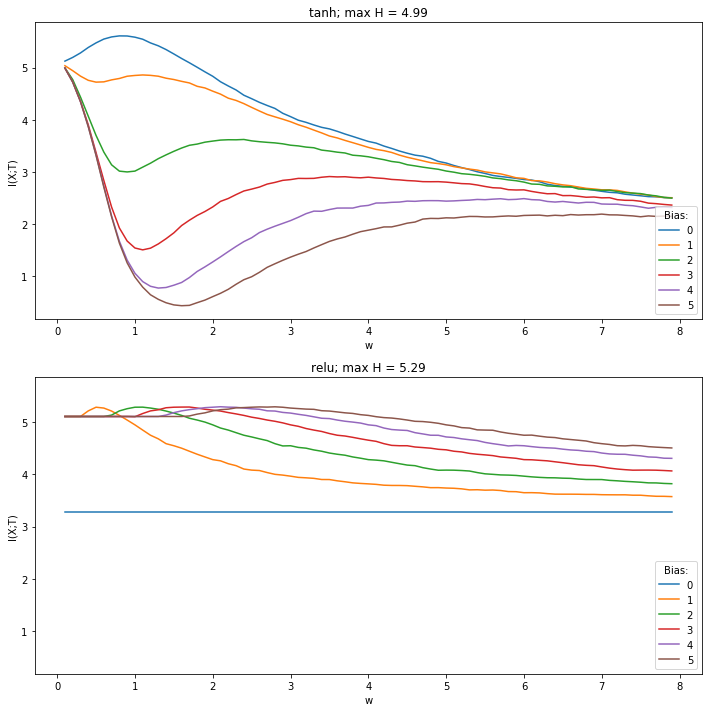

In [12]:
fig, ax = plt.subplots(nrows=len(activation_functions), figsize=(10, 10), sharey=True)
ax = ax.flat
for bias_value in bias_values:
    for ax_idx, (activation_function, Y) in enumerate(outputs_with_bias[bias_value].items()):

        mi = np.zeros(len(weights))
        for i in range(len(weights)):
            digitized, _ = np.histogram(Y[i], bins=50)
            mi[i] = stats.entropy(digitized, base=2) 

        ax[ax_idx].plot(weights,  mi)
        ax[ax_idx].legend(bias_values,loc='lower right',title='Bias:')
        ax[ax_idx].set(title=f'{activation_function}; max H = {mi.max():.2f}', xlabel='w', ylabel='I(X;T)') 
    
plt.tight_layout()
plt.show()